# WI Performance Incentives for Reducing Revocations

See [this folder](https://drive.google.com/drive/folders/1bhEJrcFBw3lj3jF0qo2vKoi60XKg5_hG) for details.

In [1]:
%run ~/github/recidiviz/recidiviz-research/utils/research_utils.py

In [4]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.simulations.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

## Policy modeling

/Users/zack/.local/share/virtualenvs/pulse-data-trReGjBw/lib/python3.7/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/zack/.local/share/virtualenvs/pulse-data-trReGjBw/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 240 results
transitions_data returned 393 results
total_population_data returned 240 results
initialization time:  10.484864711761475
simulation_time:  8.61703109741211
initialization time:  9.86812710762024
simulation_time:  8.388386011123657
initialization time:  9.966110944747925
simulation_time:  8.611936569213867


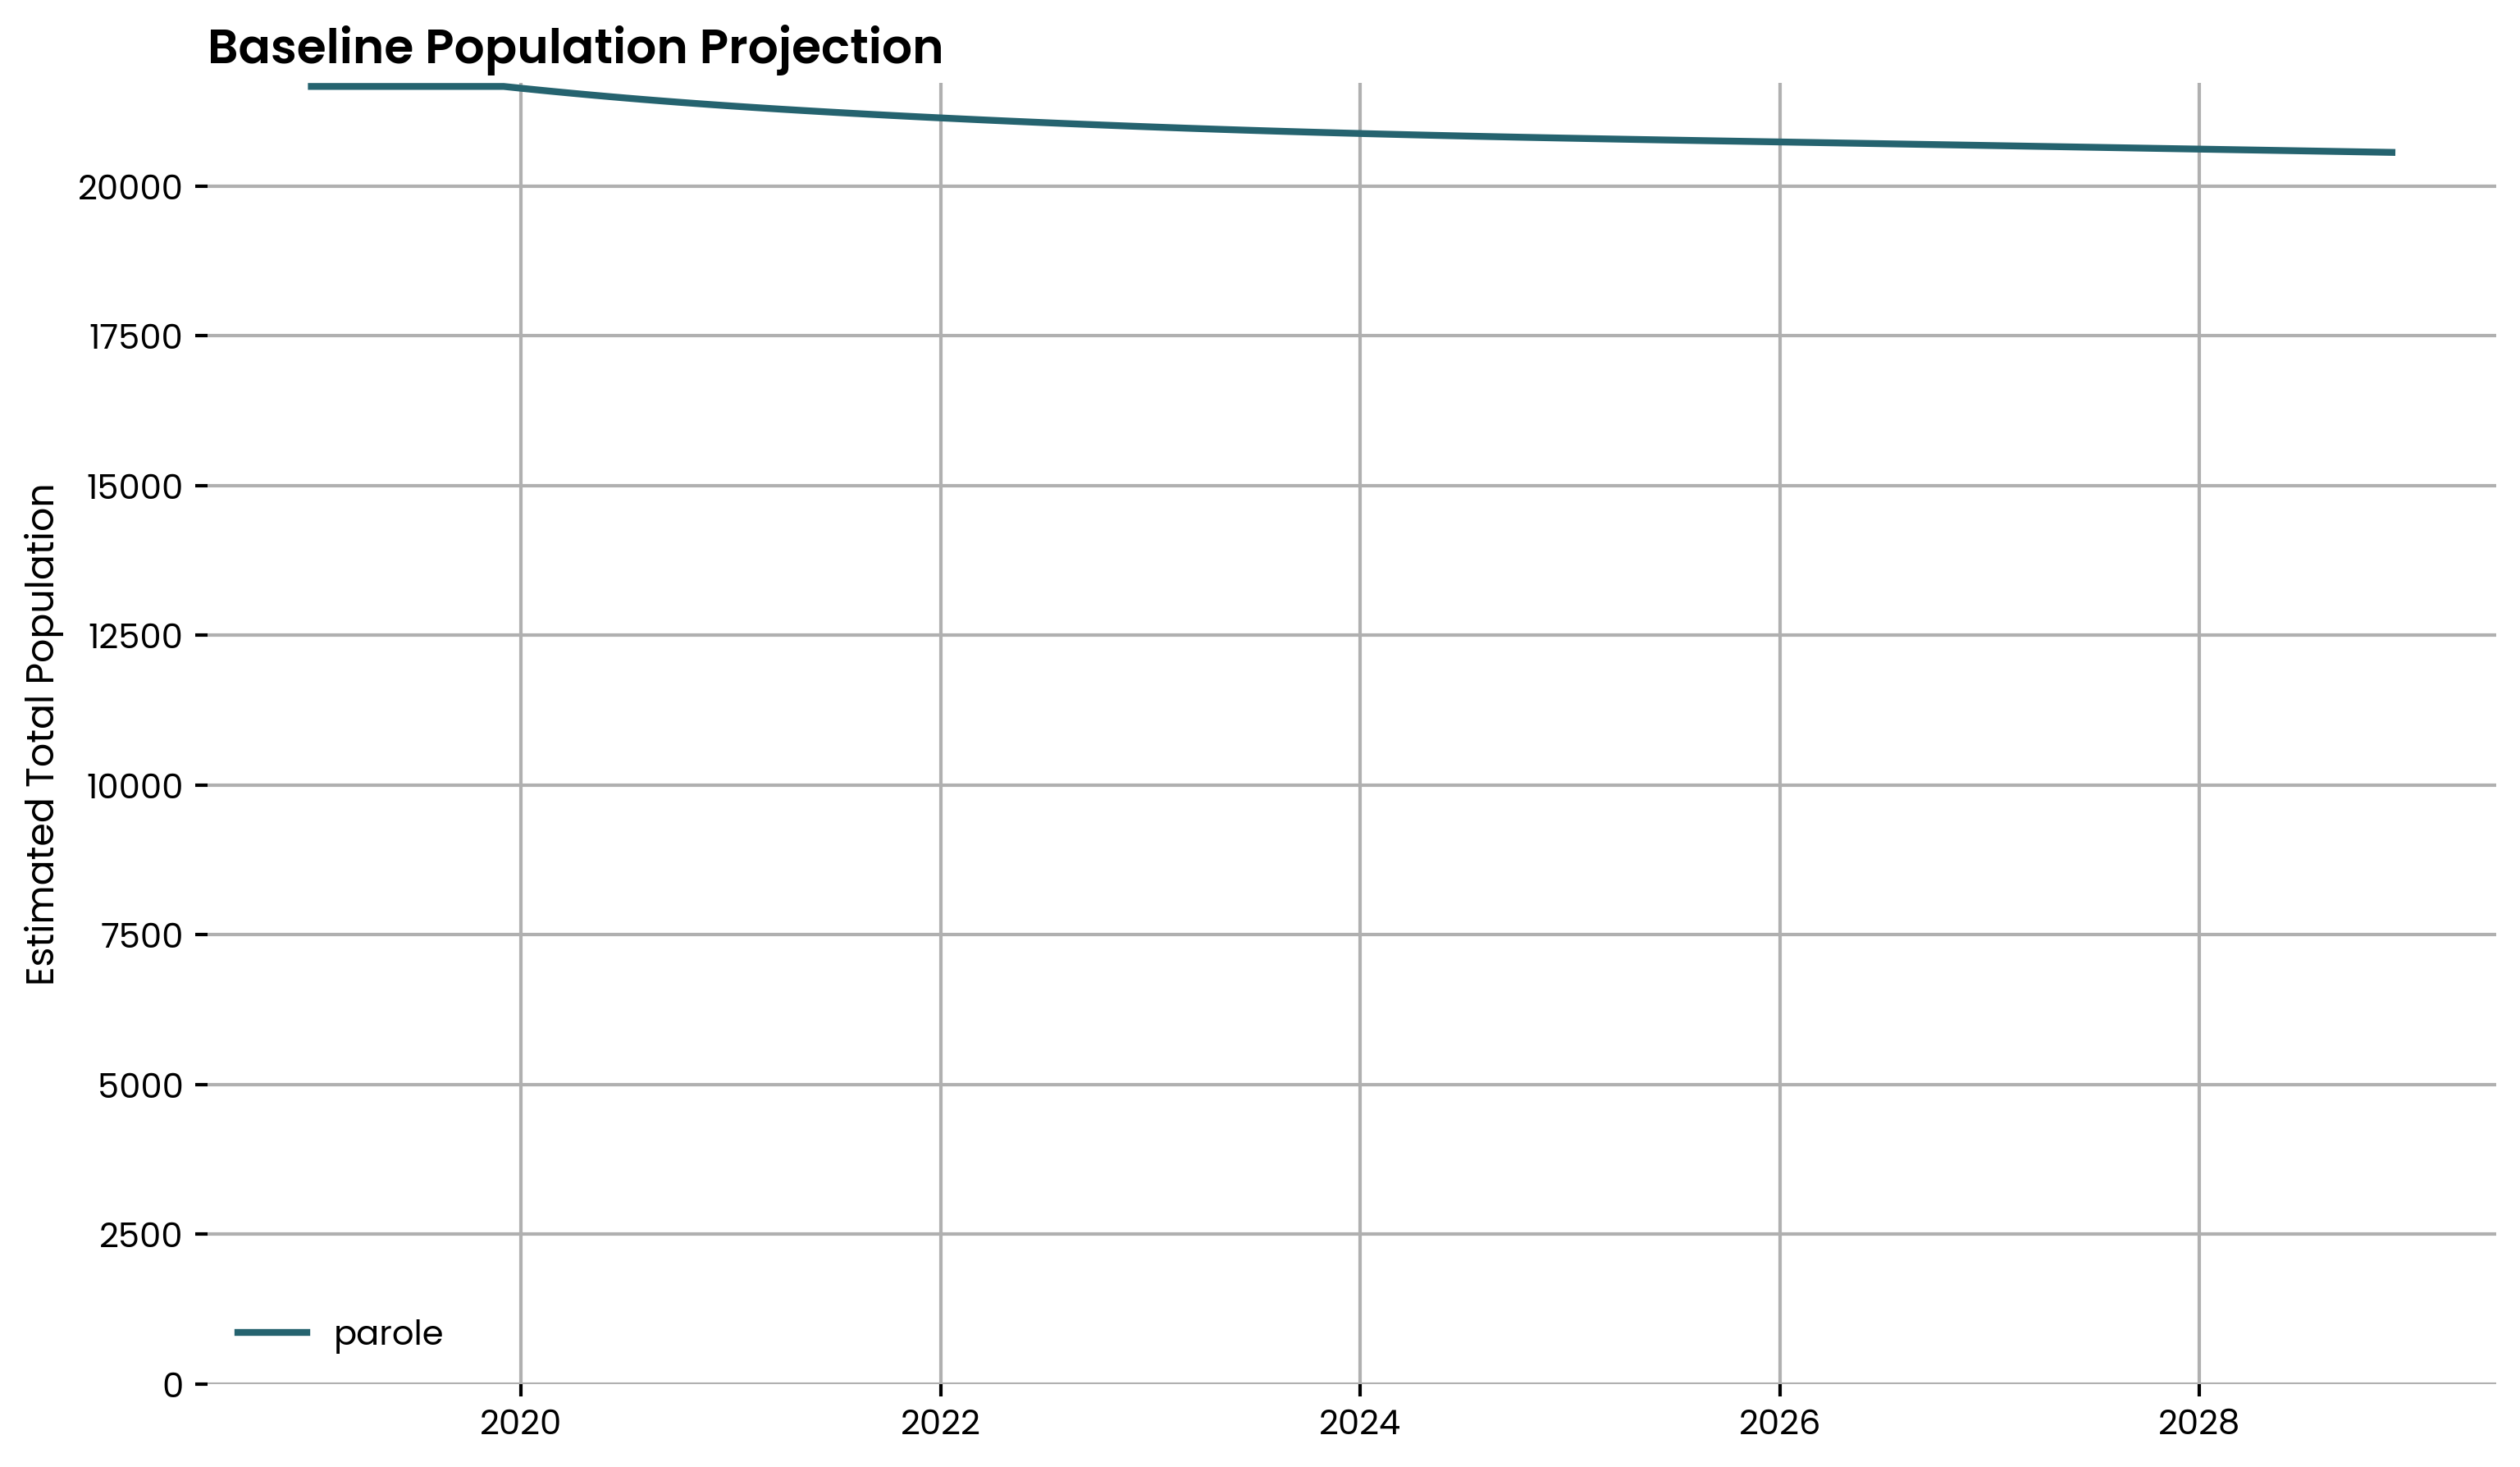

In [5]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/WI/WI_prison_model_inputs.yaml')
# testing = False
test_sim.simulate_baseline(['parole'])

initialization time:  10.102378845214844
initialization time:  9.904328346252441
simulation_time:  8.488881349563599
simulation_time:  8.443459272384644


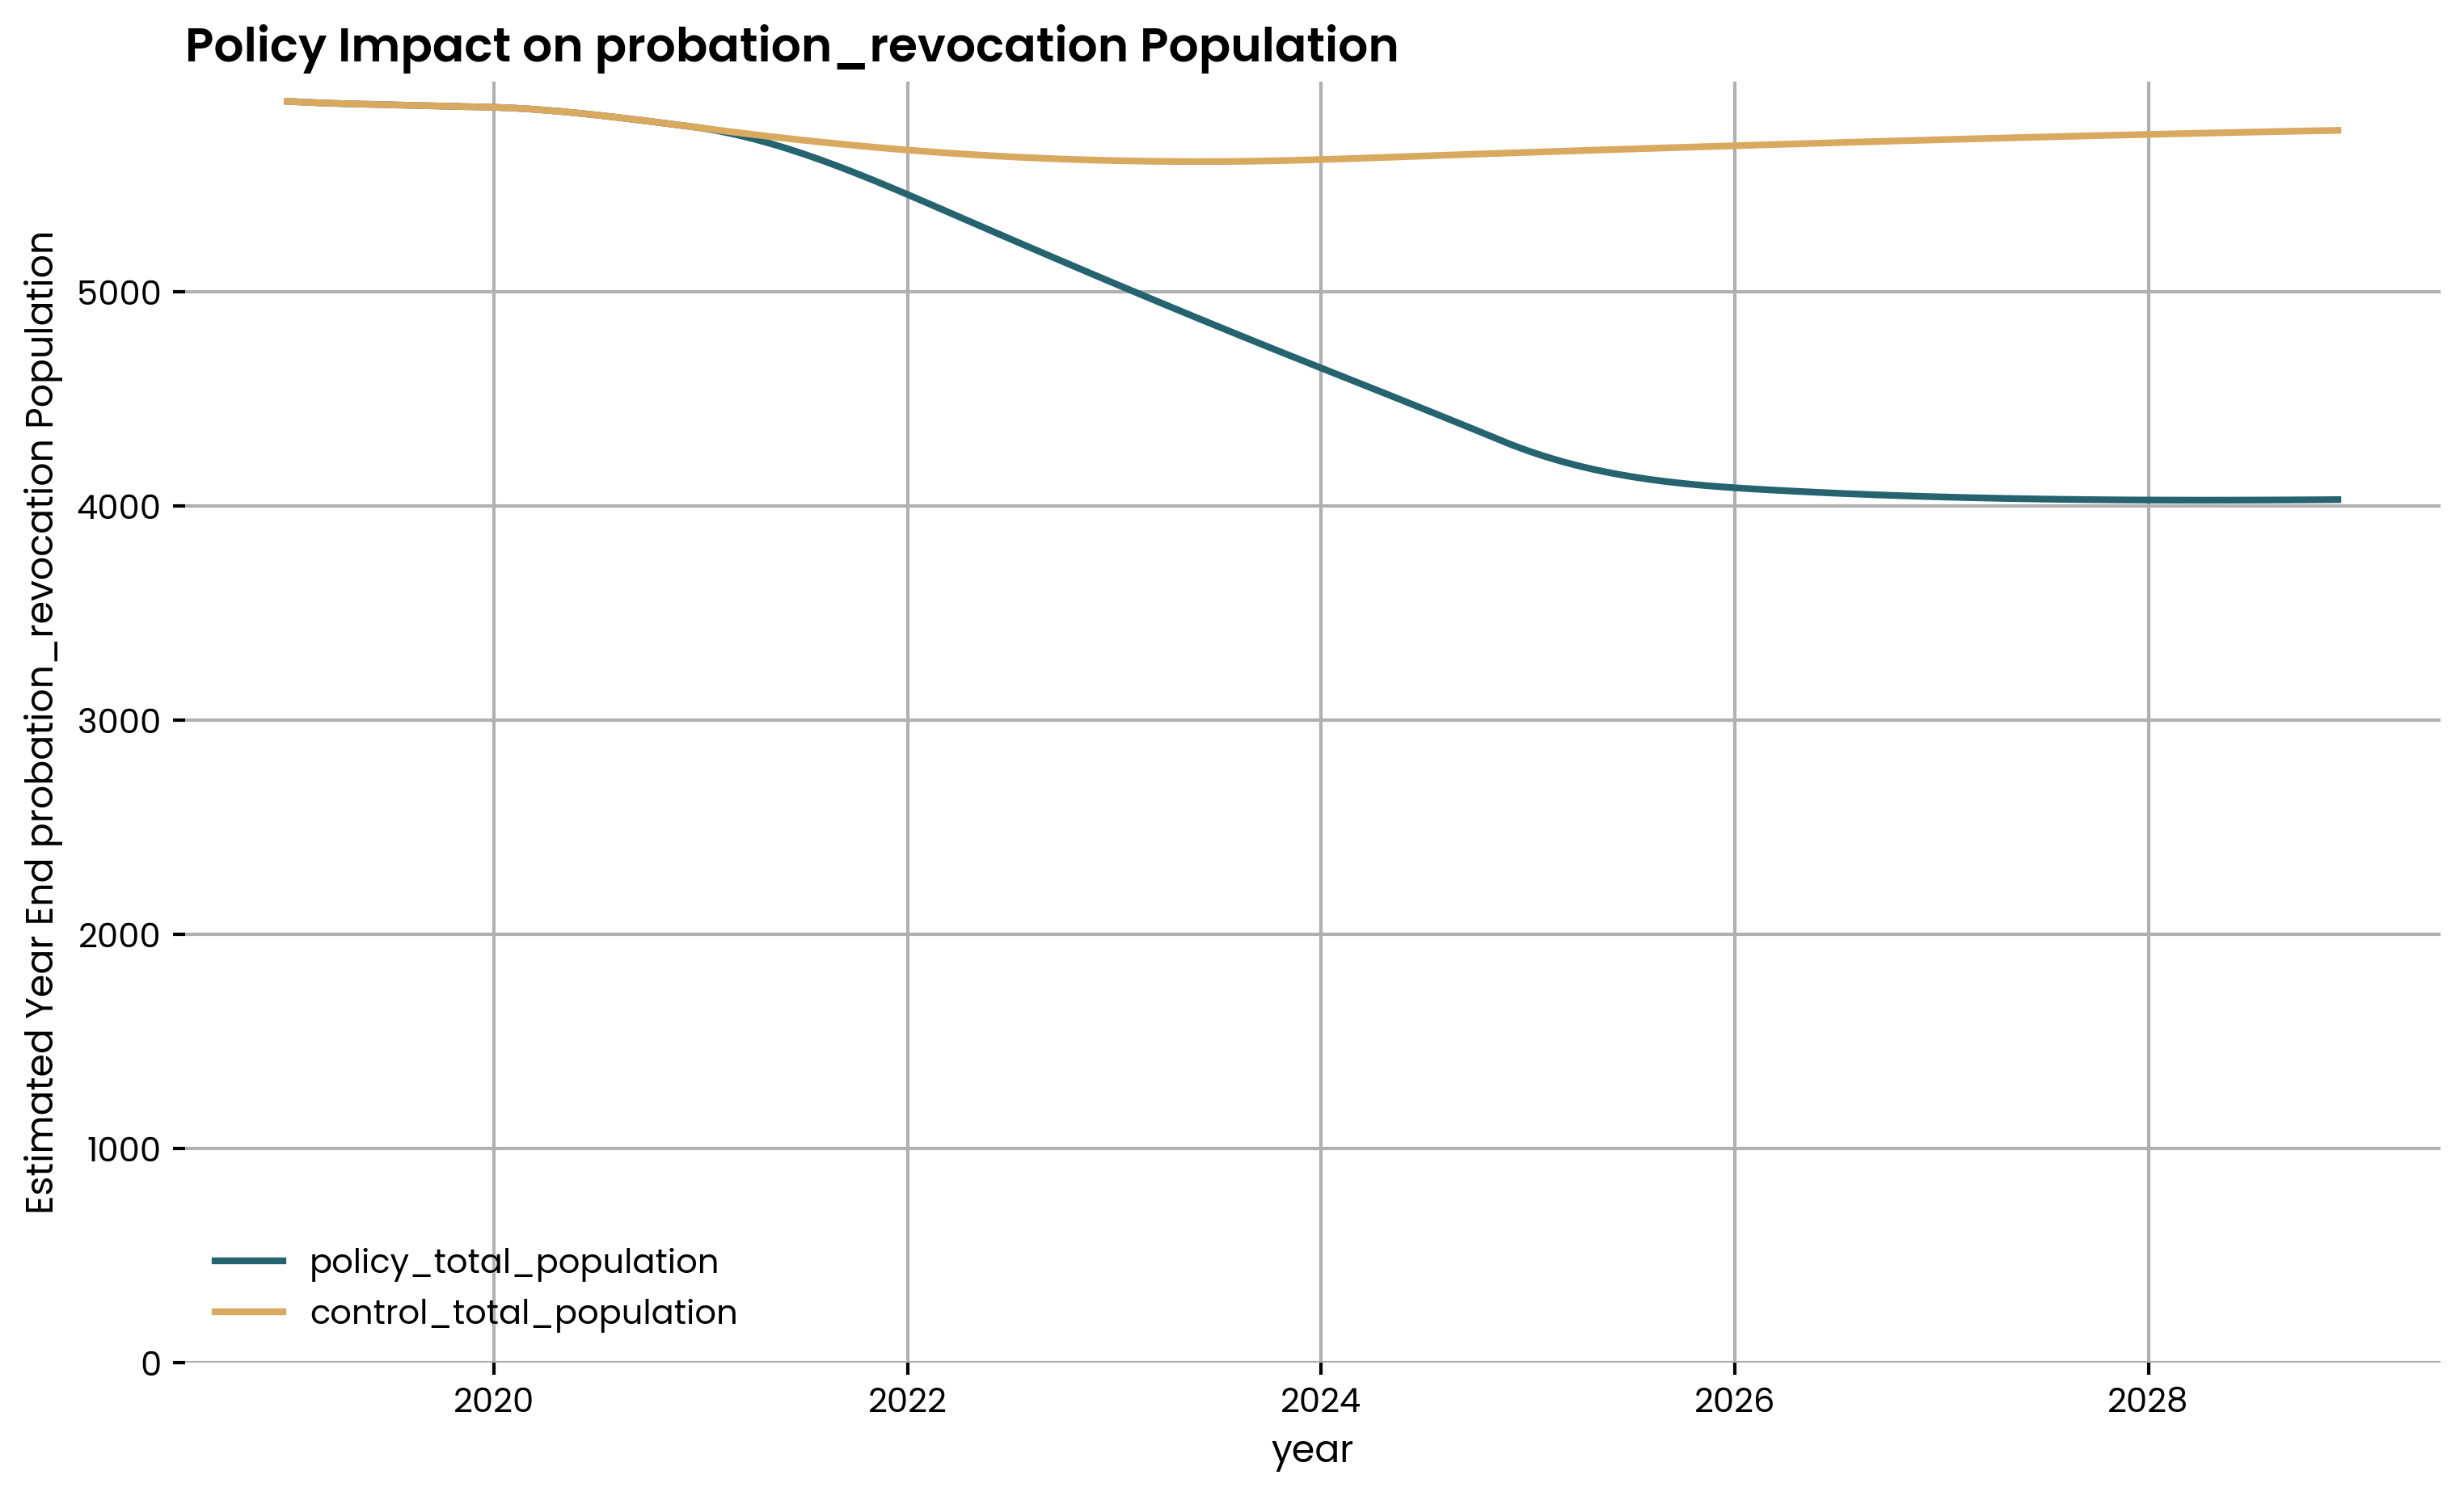

In [7]:
# test_sim = SuperSimulationFactory.build_super_simulation('../state/WI/WI_prison_model_inputs.yaml')

# Policy Option Methods
revocation_outflows = {
    'parole': 'parole_revocation',
    'probation': 'probation_revocation'
}
REVOCATION_REDUCTION = 0.3 # .1, .2, .3

def incentivize_completions(reduction, compartment, retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':[revocation_outflows[compartment]],
                       'affected_fraction': [reduction],
                       'new_outflow': ['release']
                   }),
                   reallocation_type='*',
                   retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                spark_compartment=compartment,
                sub_population={'crime_type': 'x'},
                apply_retroactive=False)
    for compartment in revocation_outflows
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation_revocation')

In [ ]:
simulation_tag = 'WI_PO_incentives_30%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [ ]:
for r in [0.1, 0.2]:
    
    # Policy Option Methods
    # revocation_outflows = same as before
    REVOCATION_REDUCTION = r

    policy_list_non_retroactive = [
        SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                    spark_compartment=compartment,
                    sub_population={'crime_type': 'x'},
                    apply_retroactive=False)
        for compartment in revocation_outflows
    ]

    test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'parole_revocation')
    
    simulation_tag = 'WI_PO_incentives_{}%'.format(int(r * 100))
    test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)